In [12]:
# Basic Libraries
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install scipy
# !pip install scikit-learn
# !pip install requests
# !pip install tabulate
# !pip install Jinja2

# Additional Libraries
# !pip install scienceplots
# !pip install praw
# !pip install deep_translator
# !pip install nltk
# !pip install gensim
# !pip install wordcloud

In [14]:
# Basic
import requests, os, re, json, time
from pprint import pprint
from IPython.display import Image, Markdown
from datetime import datetime, timedelta

# Data analysis
import numpy as np
import pandas as pd
import seaborn as sns

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scienceplots
from wordcloud import WordCloud

# Data Scraping
from deep_translator import GoogleTranslator
import praw

# PreProcessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import ast 
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# ML Models
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, precision_recall_fscore_support

In [15]:
# Conf
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

plt.style.use(['science','no-latex','light'])

pd.options.display.float_format = '{:.3f}'.format

In [4]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('vader_lexicon')

In [5]:
start_time = time.time()

## Data Scraping

Reddit data is scraped using Python and the PRAW library to collect posts and comments from localized country-specific subreddits (e.g., r/Austria, r/Bulgaria) to ensure the content originates from the intended country. The process targets the time range of 2012 to 2022, aligned with CMEF data, and focuses on keywords like "organic." Keywords are translated into the country’s primary language using the Deep Translator API, with English as a fallback. Metadata such as post titles, bodies, scores, and comments are extracted and stored in a structured CSV format. A limit of 10 posts per keyword and 50 comments per post has been applied during scraping due to time constraints. Duplicate posts are skipped using unique post IDs, and a consistency mechanism handles API and translation errors. The process adheres to Reddit’s terms of service and ensures user anonymity.

In [8]:
class RedditScraper:
    '''
    A class for scraping Reddit posts and comments with support for multilingual queries 
    and duplicate prevention.

    Attributes:
        - reddit: Reddit API instance.
        - output_file: Path to save scraped results.
        - results: List of collected posts and comments.
        - language_mapping: Maps countries to primary languages.
        - existing_data: DataFrame of previously saved data.
        - existing_posts: Set of already processed post IDs.

    Methods:
        - translate_text(text, target_language): Translate text to a target language.
        - translate_keyword(keyword, country): Translate a keyword based on country language.
        - count_existing_posts(query_keyword, country, year, subreddit): Count posts for a query.
        - save_results_to_file(): Save results to the output file.
        - fetch_posts_and_comments(...): Fetch posts and comments for a query.
        - scrape(...): Main loop to scrape across countries, subreddits, and keywords.
    '''
    def __init__(self, client_id, client_secret, user_agent, output_file):
        # Initialize Reddit API with credentials
        self.reddit = praw.Reddit(
            client_id=client_id,
            client_secret=client_secret,
            user_agent=user_agent
        )
        self.output_file = output_file
        self.results = []

        # Hardcoded language mapping for keyword translation
        self.language_mapping = {
            "Austria": "de",
            "Belgium": "nl",
            "Bulgaria": "bg",
            "Croatia": "hr",
            "Cyprus": "el",
            "Czechia": "cs",
            "Denmark": "da",
            "Estonia": "et",
            "Finland": "fi",
            "France": "fr",
            "Germany": "de",
            "Greece": "el",
            "Hungary": "hu",
            "Ireland": "en",
            "Italy": "it",
            "Latvia": "lv",
            "Lithuania": "lt",
            "Luxembourg": "fr",
            "Malta": "en",
            "Netherlands": "nl",
            "Poland": "pl",
            "Portugal": "pt",
            "Romania": "ro",
            "Slovakia": "sk",
            "Slovenia": "sl",
            "Spain": "es",
            "Sweden": "sv"
        }

        # Load existing data to avoid duplicate processing
        if os.path.exists(output_file):
            self.existing_data = pd.read_csv(output_file)
            self.existing_posts = set(self.existing_data["post_id"].tolist())
        else:
            self.existing_data = pd.DataFrame(columns=["post_id", "query_keyword"])
            self.existing_posts = set()

    # Translate text into the target language
    def translate_text(self, text, target_language):
        try:
            text = text[:4999]  # Trim text to avoid API character limit
            return GoogleTranslator(source="auto", target=target_language).translate(text)
        except Exception as e:
            print(f"Error translating text: {e}")
            return None

    # Translate keywords based on the country language
    def translate_keyword(self, keyword, country):
        target_language = self.language_mapping.get(country, "en")
        if target_language == "en":  # No translation needed for English
            return keyword
        return self.translate_text(keyword, target_language)

    # Count the number of existing posts for a specific query to prevent duplicates
    def count_existing_posts(self, query_keyword, country, year, subreddit):
        if self.existing_data.empty:
            return 0
        return self.existing_data[
            (self.existing_data["query_keyword"] == query_keyword) &
            (self.existing_data["country"] == country) &
            (self.existing_data["year"] == year) &
            (self.existing_data["subreddit"] == subreddit)
        ].shape[0]

    # Save collected results to the output file
    def save_results_to_file(self):
        if self.results:
            write_header = not os.path.exists(self.output_file) 
            pd.DataFrame(self.results).to_csv(self.output_file, index=False, mode='a', header=write_header)
            self.results = []

    # Fetch posts and comments for a given subreddit, year, and keyword
    def fetch_posts_and_comments(self, subreddit, country, year, keyword, max_posts, max_comments_per_post):
        target_language = self.language_mapping.get(country, "en")
        translated_keyword = self.translate_keyword(keyword, country)
        english_keyword = keyword

        # Iterate over translated and English keywords
        for query_keyword in {translated_keyword, english_keyword}:
            if query_keyword is None:
                print(f"Skipping query due to translation failure: {keyword}")
                continue

            # Check for existing posts
            existing_post_count = self.count_existing_posts(query_keyword, country, year, subreddit)
            if existing_post_count >= max_posts:
                print(f"Max posts reached for query: {query_keyword} in subreddit: {subreddit}")
                continue

            # Build the query
            query = f"{query_keyword}" if subreddit.lower() == country.lower() else f"{country} {query_keyword}"
            start_time = int(datetime(year, 1, 1).timestamp())
            end_time = int(datetime(year + 1, 1, 1).timestamp())

            print(f"Scraping subreddit: {subreddit}, Year: {year}, Query: {query}")

            try:
                posts = self.reddit.subreddit(subreddit).search(query=query, sort="relevance", time_filter="all")
                post_count = 0
                for post in posts:
                    if post.created_utc < start_time or post.created_utc >= end_time:
                        continue

                    if post.id in self.existing_posts:
                        continue

                    if existing_post_count + post_count >= max_posts:
                        print(f"Reached max_posts ({max_posts}) for query: {query_keyword}")
                        break

                    title_translated = self.translate_text(post.title, "en") if target_language != "en" else post.title
                    body_translated = self.translate_text(post.selftext, "en") if target_language != "en" else post.selftext

                    if title_translated is None or body_translated is None:
                        print(f"Skipping post due to translation failure. Post ID: {post.id}")
                        continue

                    # Prepare post data
                    post_data = {
                        "post_id": post.id,
                        "subreddit": subreddit,
                        "country": country,
                        "year": year,
                        "query_keyword": query_keyword,
                        "title": title_translated,
                        "body": body_translated,
                        "score": post.score,
                        "upvote_ratio": post.upvote_ratio,
                        "created_utc": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                    }

                    # Translate comments
                    post.comments.replace_more(limit=None)
                    translated_comments = []
                    for i, comment in enumerate(post.comments.list()):
                        if i >= max_comments_per_post:
                            break
                        comment_translated = self.translate_text(comment.body, "en") if target_language != "en" else comment.body
                        if comment_translated is None:
                            print(f"Skipping comment due to translation failure.")
                            continue
                        translated_comments.append(comment_translated)

                    post_data["comments"] = translated_comments
                    self.results.append(post_data)
                    self.existing_posts.add(post.id)
                    post_count += 1
            except Exception as e:
                print(f"Error fetching data: {e}")
                time.sleep(5)

    # Main scraping loop to iterate over countries, subreddits, and keywords
    def scrape(self, country_subreddits, start_year, end_year, keywords, max_posts, max_comments_per_post):
        try:
            for country, subreddits in country_subreddits.items():
                for year in range(start_year, end_year + 1):
                    for keyword in keywords:
                        for subreddit in subreddits:
                            self.fetch_posts_and_comments(
                                subreddit, country, year, keyword, max_posts, max_comments_per_post
                            )
                            self.save_results_to_file()
        except KeyboardInterrupt:
            print("Interrupted! Saving progress...")
            self.save_results_to_file()

        self.save_results_to_file()
        print("Scraping completed.")


In [9]:
scraper = RedditScraper(
    client_id="", #INSERT API KEYS
    client_secret="", #INSERT API KEYS
    user_agent="RedditScraper:v1.0 (by /u/sba24277)",
    output_file="data/reddit_scraped_data.csv"
)

country_subreddits = {
    "Austria": ["Austria"],
    "Belgium": ["Belgium"],
    "Bulgaria": ["Bulgaria"],
    "Croatia": ["Croatia"],
    "Cyprus": ["Cyprus"],
    "Czechia": ["Czech"],
    "Denmark": ["Denmark"],
    "Estonia": ["europe"],
    "Finland": ["Finland"],
    "France": ["France"],
    "Germany": ["Germany"],
    "Greece": ["Greece"],
    "Hungary": ["Hungary"],
    "Ireland": ["Ireland"],
    "Italy": ["Italy"],
    "Latvia": ["Latvia"],
    "Lithuania": ["Lithuania"],
    "Luxembourg": ["Luxembourg"],
    "Malta": ["Malta"],
    "Netherlands": ["Netherlands"],
    "Poland": ["Poland"],
    "Portugal": ["Portugal"],
    "Romania": ["Romania"],
    "Slovakia": ["Slovakia"],
    "Slovenia": ["Slovenia"],
    "Spain": ["Spain"],
    "Sweden": ["Sweden"]
}

In [10]:
# Scraping already completed; if run, a data check will execute for each country and year
# scraper.scrape(
#     country_subreddits=country_subreddits,
#     start_year=2012,
#     end_year=2022,
#     keywords=["organic"],
#     max_posts=10,
#     max_comments_per_post=50
# )

Scraping subreddit: Austria, Year: 2012, Query: organic
Scraping subreddit: Austria, Year: 2012, Query: Bio
Scraping subreddit: Austria, Year: 2013, Query: organic
Scraping subreddit: Austria, Year: 2013, Query: Bio
Scraping subreddit: Austria, Year: 2014, Query: organic
Scraping subreddit: Austria, Year: 2014, Query: Bio
Scraping subreddit: Austria, Year: 2015, Query: organic
Skipping comment due to translation failure.
Scraping subreddit: Austria, Year: 2015, Query: Bio
Scraping subreddit: Austria, Year: 2016, Query: organic
Scraping subreddit: Austria, Year: 2016, Query: Bio
Skipping comment due to translation failure.
Scraping subreddit: Austria, Year: 2017, Query: organic
Scraping subreddit: Austria, Year: 2017, Query: Bio
Scraping subreddit: Austria, Year: 2018, Query: organic
Scraping subreddit: Austria, Year: 2018, Query: Bio
Skipping comment due to translation failure.
Scraping subreddit: Austria, Year: 2019, Query: organic
Scraping subreddit: Austria, Year: 2019, Query: Bio
S

## Feature extraction

To prepare the Reddit dataset for analysis, several preprocessing steps were applied to ensure clean and consistent text data. The processed text was thoroughly reviewed to confirm the absence of noise and irrelevant entries. 

| Step                                | Description                                                                                 | Rationale                                                                                      |
|-------------------------------------|---------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| **URL Removal**                     | Identified and removed URLs (e.g., `http://example.com`) using regular expressions.         | URLs do not contribute meaningful context to text analysis and could introduce noise.         |
| **Special Characters & Numbers**    | Removed special characters, punctuation, and numeric values for cleaner text.              | Simplifies text and focuses on meaningful linguistic content, reducing noise.                 |
| **Lowercase Conversion**            | Converted all text to lowercase to ensure uniformity and avoid duplication from case sensitivity. | Prevents issues caused by case-sensitive duplication (e.g., "Organic" vs. "organic").         |
| **Stopword Removal**                | Removed common stopwords using a combined list from Gensim and NLTK for broader coverage.  | Eliminates non-informative words to improve the focus on meaningful terms during analysis.    |
| **Irrelevant Content Exclusion**    | Excluded entries marked as "delete" or "remove" to filter out irrelevant or missing content.| Avoids processing incomplete or irrelevant data that does not contribute to insights.         |
| **Tokenization**                    | Split text into individual words using NLTK's `word_tokenize`.                             | Breaks down text into manageable components for analysis and further processing.              |
| **Lemmatization**                   | Reduced words to their base forms using NLTK's `WordNetLemmatizer` (e.g., "running" → "run"). | Groups words with similar meanings, reducing dimensionality and improving analysis accuracy.  |
| **POS Tagging for Lemmatization**   | Performed POS tagging using NLTK's `pos_tag` to ensure accurate lemmatization.             | Ensures lemmatization considers grammatical roles, improving the reliability of results.      |
| **Duplicate Removal**               | Dropped duplicate rows to eliminate redundancy.                                            | Reduces bias and ensures each data point contributes uniquely to the analysis.               |
| **Final Review**                    | Reviewed processed text to confirm the removal of noise and irrelevant entries.            | Ensures data quality and readiness for meaningful analysis.                                   |

In [18]:
print(sorted(stopwords.words('english')))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [8]:
print(sorted(STOPWORDS))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'foun

In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|[\/]', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    tokens = word_tokenize(text)
    stop_words = set(STOPWORDS).union(set(stopwords.words('english')))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tokens]
    return ' '.join(tokens)

In [8]:
file_name = 'data/reddit_scraped_data.csv'
df_reddit = pd.read_csv(file_name)
df_reddit.head()

,post_id,subreddit,country,year,query_keyword,title,body,score,upvote_ratio,created_utc,comments
0,x086e,Austria,Austria,2012,organic,Animal rights organization/activists in Austria?,NaN,0,0.50,2012-07-23 07:17:14,[]
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,['Canadian who graduated with a Masters from t...
2,3j34fi,Austria,Austria,2015,organic,"Drei charged us over 90 Euros incorrectly, and...",This didn't happen to my but to my SO.\n\nShe ...,0,0.50,2015-08-31 14:05:16,"[""I don't think there is much you can do. The..."
3,2tnqv8,Austria,Austria,2015,organic,Hi Austria! Trying to identify some pics....,"Hi, so the first time I went to Austria and Ge...",9,0.91,2015-01-25 22:44:44,"[""At least for the second pic I'd say somewher..."
4,34lokb,Austria,Austria,2015,organic,Death threat via email is not considered a dea...,NaN,24,0.89,2015-05-02 07:01:49,"[""In Austria, the public prosecutor's office i..."


In [10]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   post_id        1357 non-null   object 
 1   subreddit      1357 non-null   object 
 2   country        1357 non-null   object 
 3   year           1357 non-null   int64  
 4   query_keyword  1357 non-null   object 
 5   title          1357 non-null   object 
 6   body           811 non-null    object 
 7   score          1357 non-null   int64  
 8   upvote_ratio   1357 non-null   float64
 9   created_utc    1357 non-null   object 
 10  comments       1357 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 116.7+ KB


In [12]:
def parse_comments(comment_str):
    try:
        return ast.literal_eval(comment_str)
    except (ValueError, SyntaxError):
        return []

df_reddit['comments'] = df_reddit['comments'].apply(parse_comments)
df_reddit.head()

,post_id,subreddit,country,year,query_keyword,title,body,score,upvote_ratio,created_utc,comments
0,x086e,Austria,Austria,2012,organic,Animal rights organization/activists in Austria?,NaN,0,0.50,2012-07-23 07:17:14,[]
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,[Canadian who graduated with a Masters from th...
2,3j34fi,Austria,Austria,2015,organic,"Drei charged us over 90 Euros incorrectly, and...",This didn't happen to my but to my SO.\n\nShe ...,0,0.50,2015-08-31 14:05:16,[I don't think there is much you can do. The ...
3,2tnqv8,Austria,Austria,2015,organic,Hi Austria! Trying to identify some pics....,"Hi, so the first time I went to Austria and Ge...",9,0.91,2015-01-25 22:44:44,[At least for the second pic I'd say somewhere...
4,34lokb,Austria,Austria,2015,organic,Death threat via email is not considered a dea...,NaN,24,0.89,2015-05-02 07:01:49,"[In Austria, the public prosecutor's office is..."


In [14]:
df_reddit = df_reddit.explode('comments')
df_reddit.head()

,post_id,subreddit,country,year,query_keyword,title,body,score,upvote_ratio,created_utc,comments
0,x086e,Austria,Austria,2012,organic,Animal rights organization/activists in Austria?,NaN,0,0.50,2012-07-23 07:17:14,NaN
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,Canadian who graduated with a Masters from the...
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,AMS is just there to bully the unemployed out ...
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,> I'm told that for a person who has stayed he...
1,2to2re,Austria,Austria,2015,organic,Unable to secure a job for almost two years.,I'm a Eurasian who's half Austrian and half Ch...,13,0.86,2015-01-26 00:22:25,"If you already have lots of Austrian friends, ..."


In [16]:
df_reddit = df_reddit.melt(
    id_vars=['post_id', 'country', 'year'], 
    value_vars=['title', 'body', 'comments'], 
    var_name='source', 
    value_name='text'
).drop_duplicates()

df_reddit['text'] = df_reddit['text'].fillna('').astype(str)

df_reddit.head()

,post_id,country,year,source,text
0,x086e,Austria,2012,title,Animal rights organization/activists in Austria?
1,2to2re,Austria,2015,title,Unable to secure a job for almost two years.
41,3j34fi,Austria,2015,title,"Drei charged us over 90 Euros incorrectly, and..."
55,2tnqv8,Austria,2015,title,Hi Austria! Trying to identify some pics....
65,34lokb,Austria,2015,title,Death threat via email is not considered a dea...


In [18]:
df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31416 entries, 0 to 88673
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  31416 non-null  object
 1   country  31416 non-null  object
 2   year     31416 non-null  int64 
 3   source   31416 non-null  object
 4   text     31416 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [20]:
df_reddit['cleaned_text'] = df_reddit['text'].apply(preprocess_text)

In [21]:
md_table = df_reddit.head()
display(Markdown(md_table.to_markdown()))

|    | post_id   | country   |   year | source   | text                                                                                                         | cleaned_text                                                                |
|---:|:----------|:----------|-------:|:---------|:-------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------|
|  0 | x086e     | Austria   |   2012 | title    | Animal rights organization/activists in Austria?                                                             | animal right organization activist austria                                  |
|  1 | 2to2re    | Austria   |   2015 | title    | Unable to secure a job for almost two years.                                                                 | unable secure job year                                                      |
| 41 | 3j34fi    | Austria   |   2015 | title    | Drei charged us over 90 Euros incorrectly, and say that "maybe we will return" that money but "as a coupon". | drei charge euros incorrectly maybe return money coupon                     |
| 55 | 2tnqv8    | Austria   |   2015 | title    | Hi Austria! Trying to identify some pics....                                                                 | hi austria try identify pic                                                 |
| 65 | 34lokb    | Austria   |   2015 | title    | Death threat via email is not considered a death threat - (digital Stone Age in Austrian justice)            | death threat email consider death threat digital stone age austrian justice |

In [22]:
df_reddit = df_reddit[~df_reddit['cleaned_text'].isin(['delete', 'remove'])].drop_duplicates().dropna().reset_index(drop=True)

df_reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30766 entries, 0 to 30765
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   post_id       30766 non-null  object
 1   country       30766 non-null  object
 2   year          30766 non-null  int64 
 3   source        30766 non-null  object
 4   text          30766 non-null  object
 5   cleaned_text  30766 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


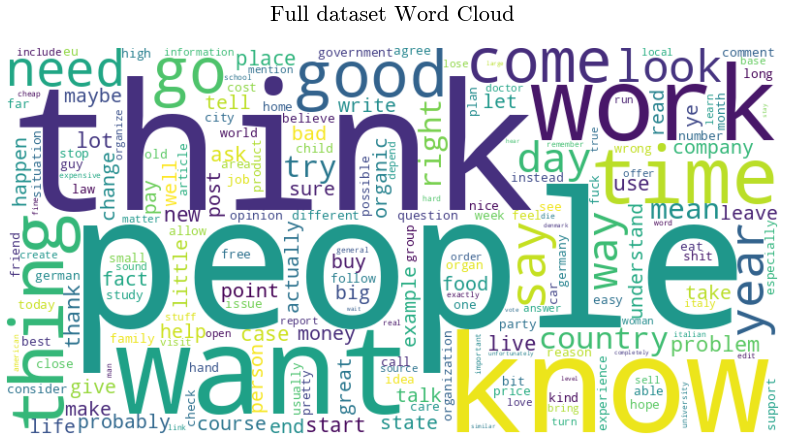

In [23]:
text_data = " ".join(df_reddit['cleaned_text'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title("Full dataset Word Cloud", fontsize=16, y=1.05)
plt.show()

## Sentiment Analysis

In this research, sentiment analysis is used to understand public opinion on organic farming across different countries and years by analyzing online textual data. The goal is to track how attitudes toward organic farming evolve over time and vary across regions, offering insights into societal influences on agricultural practices. The sentiment data is correlated with key organic farming indicators—such as the area under organic cultivation and government support—to explore whether public sentiment influences or reflects the adoption of organic farming practices.

Two machine learning models were employed for sentiment classification: Multinomial Naive Bayes (NB) and Logistic Regression (LR). Naive Bayes was chosen for its simplicity, efficiency, and effectiveness with text data, while Logistic Regression was selected for its ability to handle complex relationships in the data through regularization.

In [50]:
def grid_search_tuning(model, X_train, y_train, param_grid, cv=5, scoring=None):
    '''
    Performs hyperparameter tuning for any model using GridSearchCV and returns the best model,
    parameters, and cross-validation scores.

    Parameters:
        - model (estimator): The model/estimator to be tuned (e.g., ElasticNet, DecisionTreeRegressor).
        - X_train (array-like): Training feature set.
        - y_train (array-like): Training target values.
        - param_grid (dict): Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
        - cv (int): Number of cross-validation folds (default: 5).
        - scoring (str): Scoring metric to use for GridSearchCV (default: 'neg_mean_squared_error').

    Returns:
        - dict: Dictionary containing the best model, parameters, CV scores, and mean & std of CV scores.
    '''
    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid, 
                               cv=cv, 
                               scoring=scoring, 
                               n_jobs=-2, 
                               verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    mean_cv_score = grid_search.best_score_
    
    best_index = grid_search.best_index_
    cv_scores = [grid_search.cv_results_[f'split{i}_test_score'][best_index] for i in range(cv)]
    std_cv_score = np.std(cv_scores)
    
    print_cv_results(scoring, mean_cv_score, std_cv_score, cv_scores, best_params)
    
    return {
        'best_model': best_model,
        'best_params': best_params,
        'mean_cv_score': mean_cv_score,
        'cv_scores': cv_scores,
        'cv_results': grid_search.cv_results_
    }

In [30]:
def print_cv_results(scoring, mean_cv_score, std_cv_score, cv_scores, best_params=None):
    '''
    Utility function to print cross-validation results and optionally best parameters.

    Parameters:
        - scoring (str): The scoring metric used for cross-validation.
        - mean_cv_score (float): The mean score from cross-validation.
        - std_cv_score (float): The standard deviation of scores from cross-validation.
        - cv_scores (list or array): Cross-validation scores for each fold.
        - best_params (dict, optional): The best parameters for the model. Defaults to None.
    '''

    data = {
        "Metric": ["Score Metric", "CV Scores Mean", "CV Scores Std", "CV Folds Score"],
        "Value": [
            scoring,
            f"{mean_cv_score:.3f} (+/- {std_cv_score * 2:.3f})",
            f"{std_cv_score:.3f}",
            ', '.join([f"{score:.3f}" for score in cv_scores])
        ]
    }
    md_table = pd.DataFrame(data)

    display(Markdown(md_table.to_markdown()))
    
    if best_params is not None:
        print("\nBest Parameters:")
        pprint(best_params)

In [64]:
def evaluate_classification_performance(model, X_train, y_train, X_test, y_test, class_names=['Negative', 'Neutral', 'Positive']):
    '''
    Train a classification model and evaluate its performance on training and test sets.

    Parameters:
        - model: Classification model to be evaluated.
        - X_train, y_train: Training data and labels.
        - X_test, y_test: Test data and labels.
        - class_names: List of class labels for confusion matrix (default: ['Negative', 'Neutral', 'Positive']).
    '''
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
    report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)

    metrics_data = {
        "Metric": ["Accuracy", "Precision (Weighted)", "Recall (Weighted)", "F1 Score (Weighted)"],
        "Train Set": [
            f"{report_train['accuracy']:.3f}",
            f"{report_train['weighted avg']['precision']:.3f}",
            f"{report_train['weighted avg']['recall']:.3f}",
            f"{report_train['weighted avg']['f1-score']:.3f}"
        ],
        "Test Set": [
            f"{report_test['accuracy']:.3f}",
            f"{report_test['weighted avg']['precision']:.3f}",
            f"{report_test['weighted avg']['recall']:.3f}",
            f"{report_test['weighted avg']['f1-score']:.3f}"
        ]
    }
    metrics_df = pd.DataFrame(metrics_data)
    print("Classification Performance (Training vs Test):")
    display(Markdown(metrics_df.to_markdown(index=False)))

    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(cm_test, index=[f"Actual {cls}" for cls in class_names], columns=[f"Predicted {cls}" for cls in class_names])
    print("\nConfusion Matrix (Test Set):")
    display(Markdown(cm_df.to_markdown()))

    report_test_df = pd.DataFrame(report_test).transpose()
    report_test_df.reset_index(inplace=True)
    report_test_df.rename(columns={"index": "Class/Metric"}, inplace=True)
    print("\nClassification Report (Test Set):")
    display(Markdown(report_test_df.to_markdown(index=False)))

### VADER

The sentiment labels for the model were derived using VADER Sentiment, which classifies text as positive, negative, or neutral. As shown in Figure X, positive sentiment dominates, while neutral and negative sentiments are relatively balanced but less frequent.

In [32]:
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return "positive"
    elif sentiment_score['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

df_reddit['vader_sentiment'] = df_reddit['cleaned_text'].apply(get_vader_sentiment)

In [33]:
df_reddit.head()

,post_id,country,year,source,text,cleaned_text,vader_sentiment
0,x086e,Austria,2012,title,Animal rights organization/activists in Austria?,animal right organization activist austria,neutral
1,2to2re,Austria,2015,title,Unable to secure a job for almost two years.,unable secure job year,positive
2,3j34fi,Austria,2015,title,"Drei charged us over 90 Euros incorrectly, and...",drei charge euros incorrectly maybe return mon...,neutral
3,2tnqv8,Austria,2015,title,Hi Austria! Trying to identify some pics....,hi austria try identify pic,neutral
4,34lokb,Austria,2015,title,Death threat via email is not considered a dea...,death threat email consider death threat digit...,negative


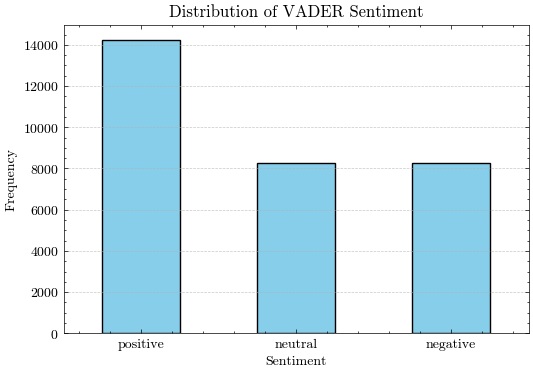

In [36]:
plt.figure(figsize=(6, 4))
df_reddit['vader_sentiment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of VADER Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### Naive Bayes

The Multinomial Naive Bayes model achieved an accuracy of 64.95% on the test set. As shown in Table X, the model performed well in identifying positive sentiment, but struggled with neutral sentiment, exhibiting a notably low recall of 28%. This issue is primarily due to the frequent misclassification of neutral posts as positive. The confusion matrix (Table X) highlights this trend, where neutral posts were predominantly categorized as positive, which contributed to the model's lower performance in predicting neutral sentiment.

In [40]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_reddit['cleaned_text']).toarray()

encoder = LabelEncoder()
df_reddit['vader_sentiment_encoded'] = encoder.fit_transform(df_reddit['vader_sentiment'])
y = df_reddit['vader_sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6545336366590835

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68      1650
           1       0.60      0.34      0.44      1610
           2       0.65      0.82      0.73      2894

    accuracy                           0.65      6154
   macro avg       0.65      0.61      0.61      6154
weighted avg       0.65      0.65      0.64      6154



In [44]:
X = df_reddit['cleaned_text']
y = df_reddit['vader_sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

nb_param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__max_features': [1000, 2000, 5000, 10000],
    'classifier__alpha': [0.01, 0.1, 1.0, 10]
}

In [52]:
nb_results = grid_search_tuning(nb_pipeline, X_train, y_train, nb_param_grid, cv=5, scoring='accuracy')

Fitting 5 folds for each of 32 candidates, totalling 160 fits


|    | Metric         | Value                             |
|---:|:---------------|:----------------------------------|
|  0 | Score Metric   | accuracy                          |
|  1 | CV Scores Mean | 0.664 (+/- 0.014)                 |
|  2 | CV Scores Std  | 0.007                             |
|  3 | CV Folds Score | 0.676, 0.667, 0.661, 0.656, 0.662 |


Best Parameters:
classifier__alpha: 0.01
vectorizer: TfidfVectorizer()
vectorizer__max_features: 5000


In [72]:
nb_model = nb_results['best_model']
evaluate_classification_performance(nb_model, X_train, y_train, X_test, y_test)

Classification Performance (Training vs Test):


| Metric               |   Train Set |   Test Set |
|:---------------------|------------:|-----------:|
| Accuracy             |       0.765 |      0.666 |
| Precision (Weighted) |       0.799 |      0.698 |
| Recall (Weighted)    |       0.765 |      0.666 |
| F1 Score (Weighted)  |       0.755 |      0.641 |


Confusion Matrix (Test Set):


|                 |   Predicted Negative |   Predicted Neutral |   Predicted Positive |
|:----------------|---------------------:|--------------------:|---------------------:|
| Actual Negative |                  973 |                  77 |                  600 |
| Actual Neutral  |                   92 |                 492 |                 1026 |
| Actual Positive |                  175 |                  85 |                 2634 |


Classification Report (Test Set):


| Class/Metric   |   precision |   recall |   f1-score |     support |
|:---------------|------------:|---------:|-----------:|------------:|
| 0              |    0.784677 | 0.589697 |   0.673356 | 1650        |
| 1              |    0.752294 | 0.30559  |   0.434629 | 1610        |
| 2              |    0.61831  | 0.910159 |   0.736371 | 2894        |
| accuracy       |    0.666071 | 0.666071 |   0.666071 |    0.666071 |
| macro avg      |    0.718427 | 0.601815 |   0.614786 | 6154        |
| weighted avg   |    0.697969 | 0.666071 |   0.640534 | 6154        |

### Logistic Regression

The Logistic Regression model outperformed Naive Bayes with an impressive test accuracy of 88.1%. Precision, recall, and F1-scores for all sentiment classes were notably higher, especially for the positive sentiment class, which achieved near-perfect performance. The confusion matrix for LR showed high accuracy in predicting both negative and positive sentiments, though neutral posts were still misclassified in some cases.

Both models were fine-tuned using grid search with cross-validation:

- Naive Bayes performed best with a smoothing parameter (alpha) of 0.01 and TfidfVectorizer with 2000 features.
- Logistic Regression showed optimal performance with C = 10 and TfidfVectorizer set to 10,000 features.

In [58]:
lr_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__max_features': [1000, 2000, 5000, 10000],
    'classifier__C': [0.01, 0.1, 1.0, 10] 
}

In [62]:
lr_results = grid_search_tuning(lr_pipeline, X_train, y_train, lr_param_grid, cv=5)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


|    | Metric         | Value                             |
|---:|:---------------|:----------------------------------|
|  0 | Score Metric   |                                   |
|  1 | CV Scores Mean | 0.874 (+/- 0.011)                 |
|  2 | CV Scores Std  | 0.005                             |
|  3 | CV Folds Score | 0.876, 0.881, 0.866, 0.871, 0.877 |


Best Parameters:
classifier__C: 10
vectorizer: TfidfVectorizer()
vectorizer__max_features: 10000


In [74]:
lr_model = lr_results['best_model']
evaluate_classification_performance(lr_model, X_train, y_train, X_test, y_test)

Classification Performance (Training vs Test):


| Metric               |   Train Set |   Test Set |
|:---------------------|------------:|-----------:|
| Accuracy             |       0.987 |      0.875 |
| Precision (Weighted) |       0.987 |      0.877 |
| Recall (Weighted)    |       0.987 |      0.875 |
| F1 Score (Weighted)  |       0.987 |      0.875 |


Confusion Matrix (Test Set):


|                 |   Predicted Negative |   Predicted Neutral |   Predicted Positive |
|:----------------|---------------------:|--------------------:|---------------------:|
| Actual Negative |                 1331 |                 164 |                  155 |
| Actual Neutral  |                   71 |                1436 |                  103 |
| Actual Positive |                  124 |                 150 |                 2620 |


Classification Report (Test Set):


| Class/Metric   |   precision |   recall |   f1-score |     support |
|:---------------|------------:|---------:|-----------:|------------:|
| 0              |    0.872215 | 0.806667 |   0.838161 | 1650        |
| 1              |    0.820571 | 0.891925 |   0.854762 | 1610        |
| 2              |    0.910354 | 0.905321 |   0.907831 | 2894        |
| accuracy       |    0.875366 | 0.875366 |   0.875366 |    0.875366 |
| macro avg      |    0.867714 | 0.867971 |   0.866918 | 6154        |
| weighted avg   |    0.87664  | 0.875366 |   0.875267 | 6154        |

Logistic Regression emerged as the superior model for this sentiment classification task, achieving higher accuracy and better class balance compared to Naive Bayes. While Naive Bayes provided a useful baseline, its performance—particularly for the neutral sentiment class—was less reliable. Future work could explore additional text preprocessing techniques and class balancing strategies to further enhance model performance, especially for neutral sentiment posts.

### Model evaluation

Confusion matrices were used to provide an intuitive understanding of the models' ability to distinguish between the three classes (Negative, Neutral, Positive), highlighting both correct predictions and misclassifications. Accuracy, precision, recall, and F1-score were summarized to assess different aspects of performance: accuracy measures the overall correctness of predictions, precision evaluates how many predicted positives are actually correct, recall assesses the ability to identify all relevant instances, and F1-score balances precision and recall. Additionally, ROC curves and Precision-Recall curves were employed to evaluate the models across various decision thresholds. The ROC curve illustrates the trade-off between true positives and false positives, while the Precision-Recall curve highlights performance for imbalanced classes by focusing on precision and sensitivity.

In [107]:
def compare_models(models, X_test, y_test, model_names, class_names):
    '''
    Compare multiple classification models using metrics and visualizations.

    Parameters:
        - models: List of trained classification models.
        - X_test, y_test: Test data and labels.
        - model_names: Names of the models for labeling.
        - class_names: List of class names for the confusion matrix.

    Returns:
        metrics_df: DataFrame containing accuracy, precision, recall, and F1 score for each model.
    '''
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(models))]

    metrics = []
    sns.set_palette("Set2")

    # Create grid for confusion matrices
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 3.5))
    if n_models == 1:
        axes = [axes]

    # Evaluate each model
    for idx, (model, name) in enumerate(zip(models, model_names)):
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        metrics.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})

        # Plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
        axes[idx].set_title(f"Confusion Matrix for {name}")
        axes[idx].set_xlabel("Predicted")
        axes[idx].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # Summary plot of metrics
    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index('Model', inplace=True)
    ax = metrics_df.plot(kind='bar', figsize=(9, 6), colormap='Set2')
    plt.title("Model Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels on bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

    return metrics_df

In [108]:
def plot_multiclass_roc_pr(models, X_test, y_test, model_names, class_names):
    '''
    Plot ROC and Precision-Recall curves for multiclass classification models.

    Parameters:
        - models: List of trained classification models.
        - X_test, y_test: Test data and labels.
        - model_names: Names of the models for labeling plots.
        - class_names: List of class labels for curves.
    '''
    colormap = {
        'negative': '#FF6F61',  # Deep red
        'neutral': '#FFCC80',   # Bright yellow
        'positive': '#4CAF50'   # Deep green
    }

    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

    for model, model_name in zip(models, model_names):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # ROC Curve
        for i, class_name in enumerate(class_names):
            y_proba = model.predict_proba(X_test)[:, i]
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba)
            roc_auc = auc(fpr, tpr)
            color = colormap.get(class_name.lower())
            axes[0].plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})", color=color)
        axes[0].plot([0, 1], [0, 1], "k--", label="Random Guess")
        axes[0].set_title(f"ROC Curve (OvR) for {model_name}")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        axes[0].legend(loc="lower right")

        # Precision-Recall Curve
        for i, class_name in enumerate(class_names):
            y_proba = model.predict_proba(X_test)[:, i]
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba)
            avg_precision = average_precision_score(y_test_bin[:, i], y_proba)
            color = colormap.get(class_name.lower())
            axes[1].plot(recall, precision, label=f"{class_name} (AP = {avg_precision:.2f})", color=color)
        axes[1].set_title(f"Precision-Recall Curve (OvR) for {model_name}")
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
        axes[1].legend(loc="lower left")

        plt.tight_layout()
        plt.show()

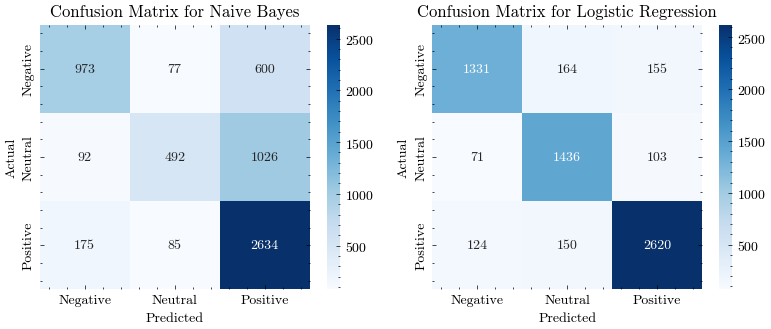

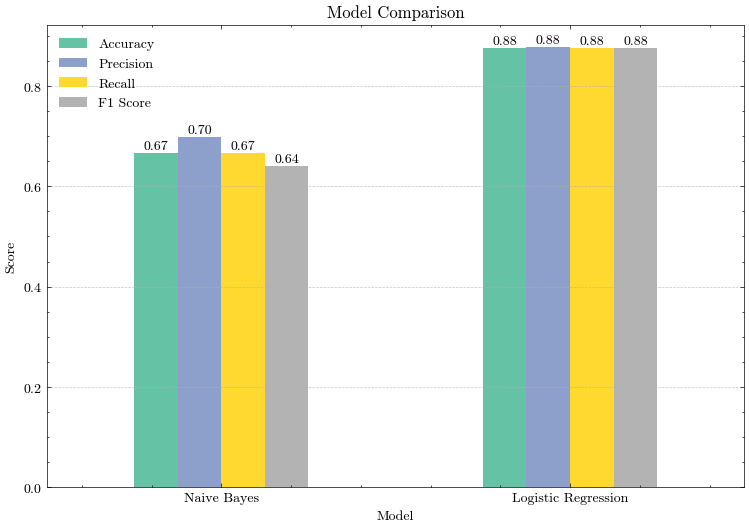

In [109]:
models = [nb_model, lr_model]
model_names = ["Naive Bayes", "Logistic Regression"]
class_names=['Negative', 'Neutral', 'Positive']
metrics_df = compare_models(models, X_test, y_test, model_names, class_names)

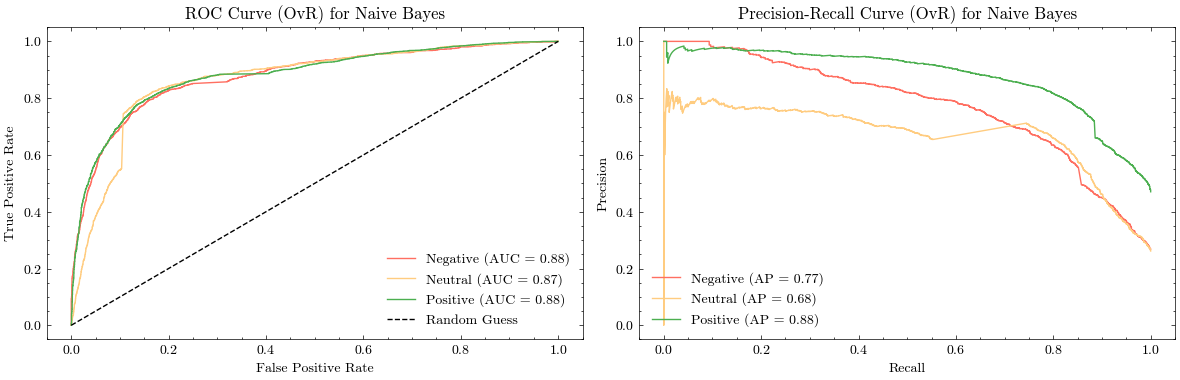

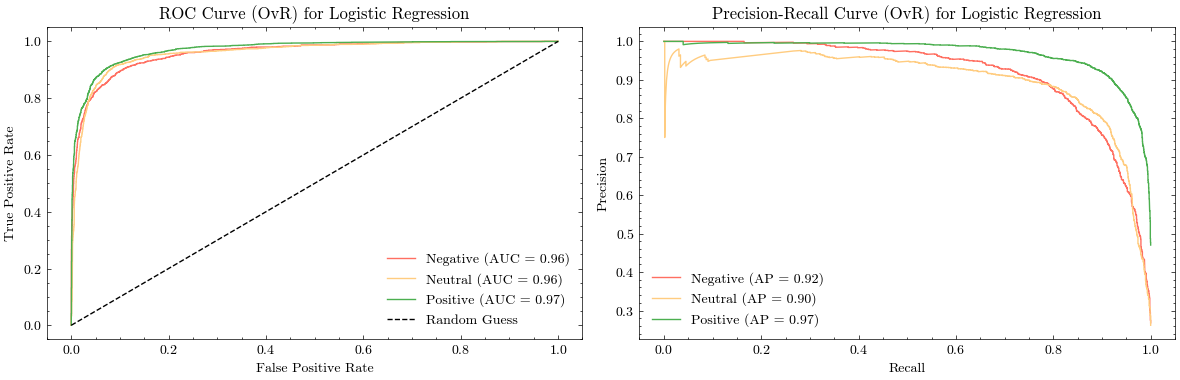

In [110]:
plot_multiclass_roc_pr(models, X_test, y_test, model_names, class_names)

## Topic Modelling

Topic modeling was employed to identify and filter posts and comments related to the "organic" keyword, ensuring that only relevant content is analyzed. The Latent Dirichlet Allocation (LDA) algorithm was selected for its ability to group terms based on co-occurrence patterns. To prepare the text for LDA, the Bag of Words (Count Vectorizer) approach was used to create a document-term matrix of raw term frequencies. This approach was chosen over TF-IDF because LDA relies on raw term counts to accurately capture word co-occurrence structures, while TF-IDF downweights frequent terms, potentially distorting key relationships.

The quality of the topics was assessed using coherence scores, which evaluate the semantic similarity of the top words in each topic. To determine the optimal number of topics, models with 3, 4, and 5 topics were evaluated based on coherence scores plot in Figure X. As shown in Table X, the 5-topic model was chosen for its clear separation of organic farming terms while minimizing unrelated content.

While Figure X indicates that models with a vocabulary size of 1000 terms often achieve slightly higher coherence scores, a manual inspection of the topic words (as shown in Table X) suggests that the 5000-term model better captures the nuances of the "organic farming" theme, compared to the max_features=1000 model, which includes unrelated terms like "example" and "problem".

Comparison of Topic Models

| **Number of Topics**   | **Observations**                                                                                           |
|---------------------|-------------------------------------------------------------------------------------------------------|
| **3 topics**        | Significant dilution observed; organic-related terms mixed with unrelated content, such as politics.  |
| **4 topics**        | Improved topic isolation but retained some overlap among topics.                                      |
| **5 topics**        | Clearest separation, with terms like "organic," "food," and "meat" grouped into a distinct topic.     |nt is needed!

Topic Words for Different Vocabulary Sizes

| **Vocabulary Size**   | **Topic Words (Topic 5)**                                                                                                                                             |
|--------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **max_features=5000** | organic, food, product, meat, buy, animal, think, good, eat, produce, use, price, farm, people, market, farmer, thing, plant, production, test               |
| **max_features=1000** | organic, good, product, food, people, think, animal, buy, meat, mean, use, produce, thank, example, problem, high, thing, know, market, farm                 |

In [28]:
def display_topics(model, feature_names, no_top_words):
    '''
    Extract and format topics with their top keywords from a trained topic model.

    Parameters:
        - model: Trained topic model.
        - feature_names: List of feature names from the document-term matrix.
        - no_top_words: Number of top keywords per topic.

    Returns:
        List of formatted topic strings with keywords.
    '''
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        keywords = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx}: {', '.join(keywords)}")
    return topics

In [30]:
def calculate_coherence_scores(X, vectorizer, max_topics=10
    '''
    Calculate coherence scores for different numbers of topics in LDA.

    Parameters:
        - X: Sparse matrix of the document-term matrix.
        - vectorizer: Fitted vectorizer with feature names.
        - max_topics: Maximum number of topics to evaluate (default: 10).

    Returns:
        List of coherence scores for topic numbers from 2 to max_topics.
    '''
    corpus = Sparse2Corpus(X, documents_columns=False)
    dictionary = Dictionary([list(vectorizer.get_feature_names_out())])

    coherence_scores = []
    for num_topics in range(2, max_topics + 1):
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)

        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
            topics.append(terms)

        coherence_model = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_scores.append(coherence_model.get_coherence())
    return coherence_scores

In [32]:
max_topics = 10

In [31]:
vectorizer = CountVectorizer(max_features=1000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 301477 stored elements in Compressed Sparse Row format>

In [32]:
start_time = time.time()

coherence_scores_1000 = calculate_coherence_scores(X, vectorizer, max_topics)

end_time = time.time()
execution_time = end_time - start_time

execution_time

768.9537484645844

In [33]:
vectorizer = CountVectorizer(max_features=2000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 367148 stored elements in Compressed Sparse Row format>

In [34]:
start_time = time.time()

coherence_scores_2000 = calculate_coherence_scores(X, vectorizer, max_topics)

end_time = time.time()
execution_time = end_time - start_time

execution_time

727.467600107193

In [35]:
vectorizer = CountVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 432429 stored elements in Compressed Sparse Row format>

In [36]:
start_time = time.time()

coherence_scores_5000 = calculate_coherence_scores(X, vectorizer, max_topics)

end_time = time.time()
execution_time = end_time - start_time

execution_time

921.6945502758026

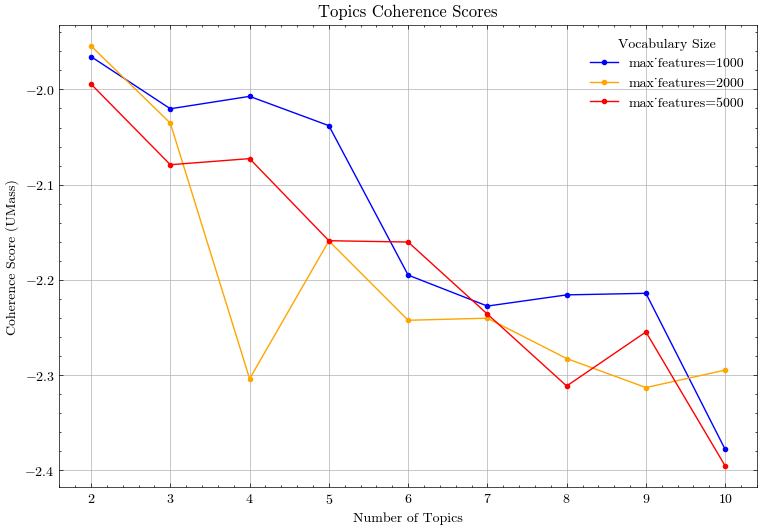

In [37]:
plt.figure(figsize=(9, 6))
plt.plot(range(2, max_topics + 1), coherence_scores_1000, marker='o', markersize=3, color='blue', label='max_features=1000')
plt.plot(range(2, max_topics + 1), coherence_scores_2000, marker='o', markersize=3, color='orange', label='max_features=2000')
plt.plot(range(2, max_topics + 1), coherence_scores_5000, marker='o', markersize=3, color='red', label='max_features=5000')
plt.title("Topics Coherence Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (UMass)")
plt.grid(True)

plt.legend(title="Vocabulary Size")
plt.show()

### Max_features=1000

In [39]:
vectorizer = CountVectorizer(max_features=1000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 301477 stored elements in Compressed Sparse Row format>

In [40]:
lda = LatentDirichletAllocation(n_components = 3,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, like, know, think, want, right, organ, time, say, thing, year, help, country, thanks, post, come, need, go, way, get',
 'Topic 1: like, organic, good, think, people, food, time, buy, go, thing, look, day, year, know, product, come, eat, place, want, price',
 'Topic 2: work, pay, money, company, year, need, job, good, problem, country, want, time, know, german, like, people, eu, month, germany, high']

In [41]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    15622
1     8668
2     6476
Name: count, dtype: int64

In [42]:
lda = LatentDirichletAllocation(n_components = 4,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, know, like, think, organ, want, right, post, time, say, thanks, thing, party, help, comment, question, need, year, write, life',
 'Topic 1: like, good, time, people, go, year, day, think, look, thing, know, get, come, buy, place, want, eat, food, lot, city',
 'Topic 2: work, pay, company, money, job, year, need, know, want, time, like, good, month, people, student, problem, car, school, thing, public',
 'Topic 3: organic, country, people, world, product, think, eu, good, mean, example, war, power, animal, food, state, problem, europe, like, use, thing']

In [43]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    12346
1     8140
2     5209
3     5071
Name: count, dtype: int64

In [44]:
lda = LatentDirichletAllocation(n_components = 5,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, know, think, organ, like, want, time, help, life, need, say, thing, family, child, year, person, feel, right, woman, get',
 'Topic 1: like, time, day, go, year, people, good, look, think, thing, place, come, get, know, want, city, lot, nice, eat, buy',
 'Topic 2: work, pay, money, company, job, need, year, want, know, time, month, like, student, school, service, good, public, university, car, problem',
 'Topic 3: organic, good, product, food, people, think, animal, buy, meat, mean, use, produce, thank, example, problem, high, thing, know, market, farm',
 'Topic 4: people, country, like, right, think, post, state, party, government, know, world, eu, article, war, read, european, power, say, want, vote']

In [45]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    9678
1    6812
2    4617
3    3823
4    5836
Name: count, dtype: int64

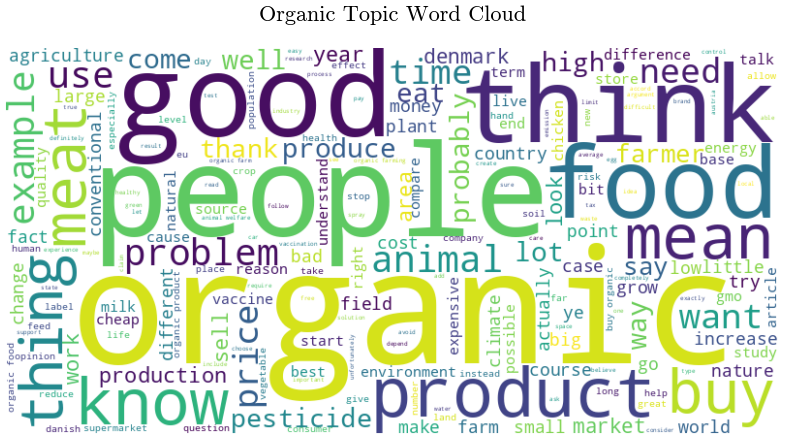

In [46]:
text_data = " ".join(df_reddit['cleaned_text'][df_reddit['assigned_topic'] == 3])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title("Organic Topic Word Cloud", fontsize=16, y=1.05)
plt.show()

### Max_features=2000

In [48]:
vectorizer = CountVectorizer(max_features=2000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 367148 stored elements in Compressed Sparse Row format>

In [49]:
lda = LatentDirichletAllocation(n_components = 3,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: know, organ, think, need, want, post, like, case, people, say, read, time, write, state, help, comment, thank, question, point, yes',
 'Topic 1: people, like, know, work, year, think, time, go, want, thing, day, come, country, right, good, get, look, live, place, way',
 'Topic 2: organic, good, food, buy, like, think, use, product, price, company, eat, thing, pay, time, people, meat, cost, money, problem, need']

In [50]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    11836
1    12359
2     6571
Name: count, dtype: int64

In [51]:
lda = LatentDirichletAllocation(n_components = 4,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: organ, know, think, need, people, post, want, comment, thank, case, like, help, say, time, read, write, question, doctor, article, ask',
 'Topic 1: people, like, know, think, time, year, go, want, come, day, thing, look, work, get, good, right, live, country, place, way',
 'Topic 2: work, year, company, problem, people, country, think, pay, high, eu, thing, need, money, good, world, power, state, time, way, want',
 'Topic 3: organic, good, food, buy, like, product, think, eat, car, price, meat, use, time, thing, know, people, animal, water, want, sell']

In [52]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0     9293
1    10924
2     5269
3     5280
Name: count, dtype: int64

In [53]:
lda = LatentDirichletAllocation(n_components = 5,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: organ, need, people, help, know, want, case, doctor, time, body, day, ask, donor, question, family, test, contact, think, number, donate',
 'Topic 1: people, like, year, know, time, day, go, live, want, come, country, think, work, get, place, city, thing, look, good, friend',
 'Topic 2: work, company, year, people, problem, country, eu, job, think, high, pay, need, money, power, state, government, thing, course, tax, time',
 'Topic 3: organic, food, buy, good, product, like, eat, price, meat, think, use, car, animal, time, water, sell, people, thing, cheap, know',
 'Topic 4: like, think, right, know, say, people, good, thing, post, read, yes, want, look, write, point, talk, time, thanks, bad, way']

In [54]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    6504
1    7396
2    4485
3    4453
4    7928
Name: count, dtype: int64

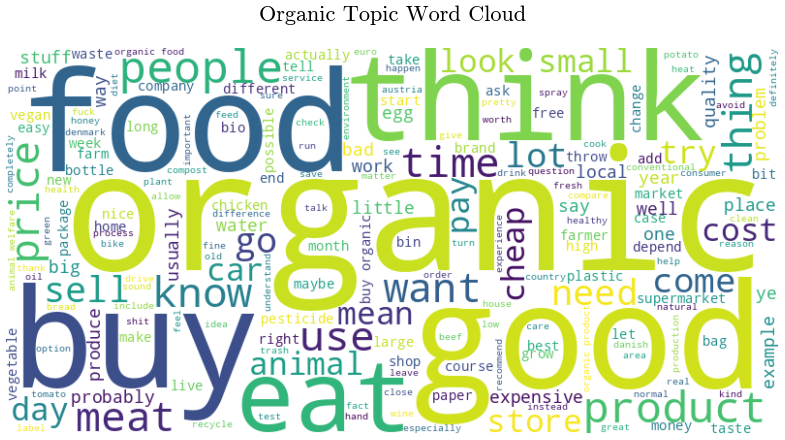

In [55]:
text_data = " ".join(df_reddit['cleaned_text'][df_reddit['assigned_topic'] == 3])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title("Organic Topic Word Cloud", fontsize=16, y=1.05)
plt.show()

### Max_features=5000

In [64]:
vectorizer = CountVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df_reddit['cleaned_text'])
X

<30766x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 432429 stored elements in Compressed Sparse Row format>

In [58]:
lda = LatentDirichletAllocation(n_components = 3,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, like, think, country, right, work, want, say, time, know, thing, problem, state, way, year, company, case, government, point, money',
 'Topic 1: organic, organ, food, buy, good, like, think, product, price, eat, use, people, want, meat, know, thing, time, need, animal, year',
 'Topic 2: like, know, people, time, think, year, good, day, look, work, go, want, come, help, thanks, thing, need, ask, get, try']

In [59]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    11611
1     6723
2    12432
Name: count, dtype: int64

In [60]:
lda = LatentDirichletAllocation(n_components = 4,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, like, work, think, right, want, know, time, say, thing, year, problem, country, way, company, case, state, point, good, go',
 'Topic 1: organ, like, want, think, good, buy, pay, car, year, know, price, people, time, cost, yes, need, donor, money, get, use',
 'Topic 2: like, know, people, look, think, good, time, day, help, thanks, year, go, come, work, want, ask, try, place, need, thing',
 'Topic 3: organic, food, product, meat, think, animal, people, country, good, eat, war, use, produce, world, like, buy, farm, plant, thing, waste']

In [61]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    10834
1     5489
2    10216
3     4227
Name: count, dtype: int64

In [66]:
lda = LatentDirichletAllocation(n_components = 5,
                                random_state = 42)

X_topics = lda.fit_transform(X)

display_topics(lda, vectorizer.get_feature_names_out(), 20)

['Topic 0: people, like, think, right, country, thing, say, know, want, state, time, way, government, problem, party, point, world, talk, understand, case',
 'Topic 1: organ, want, people, car, think, yes, know, like, donor, die, donate, need, life, donation, year, body, opt, power, time, dead',
 'Topic 2: like, know, people, think, look, thanks, help, good, day, time, go, post, come, thank, want, ask, place, year, question, try',
 'Topic 3: organic, food, product, meat, buy, animal, think, good, eat, produce, use, price, farm, people, market, farmer, thing, plant, production, test',
 'Topic 4: work, like, year, pay, time, good, company, money, month, day, thing, job, want, know, need, go, think, get, people, lot']

In [70]:
df_reddit['assigned_topic'] = X_topics.argmax(axis=1)
df_reddit['assigned_topic'].value_counts().sort_index()

assigned_topic
0    9096
1    3808
2    8499
3    3382
4    5981
Name: count, dtype: int64

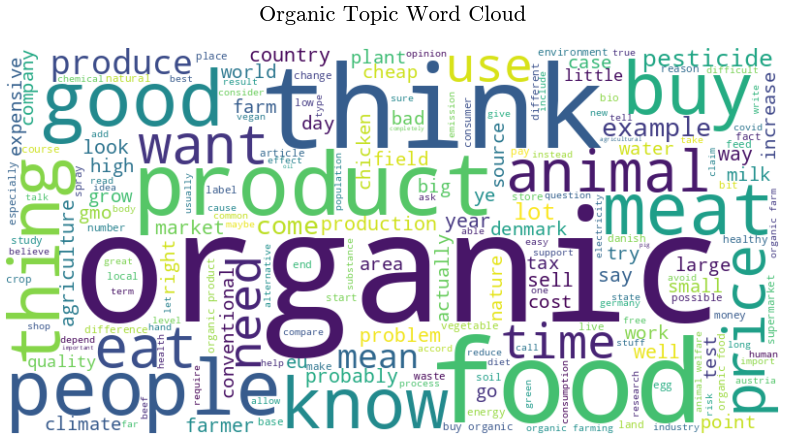

In [72]:
text_data = " ".join(df_reddit['cleaned_text'][df_reddit['assigned_topic'] == 3])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.title("Organic Topic Word Cloud", fontsize=16, y=1.05)
plt.show()

### Topic Evaluation

In [74]:
organic_topic_index=3

In [76]:
md_table = df_reddit[df_reddit['assigned_topic'] == organic_topic_index].head()
display(Markdown(md_table.to_markdown()))

|    | post_id   | country   |   year | source   | text                                                                                 | cleaned_text                                                |   assigned_topic |
|---:|:----------|:----------|-------:|:---------|:-------------------------------------------------------------------------------------|:------------------------------------------------------------|-----------------:|
| 11 | 4k3gi5    | Austria   |   2016 | title    | The Organic Prayer for the 2016 Election                                             | organic prayer election                                     |                3 |
| 25 | 8lqap7    | Austria   |   2018 | title    | Study: Organic could feed Austria. The pros and cons of a complete switch to organic | study organic feed austria pros con complete switch organic |                3 |
| 26 | 8d4u4z    | Austria   |   2018 | title    | Agricultural/agricultural or organic influencers in Austria?                         | agricultural agricultural organic influencers austria       |                3 |
| 34 | c7agzx    | Austria   |   2019 | title    | Organic or regional?                                                                 | organic regional                                            |                3 |
| 36 | dp7hnn    | Austria   |   2019 | title    | Normal VS BIO                                                                        | normal v bio                                                |                3 |

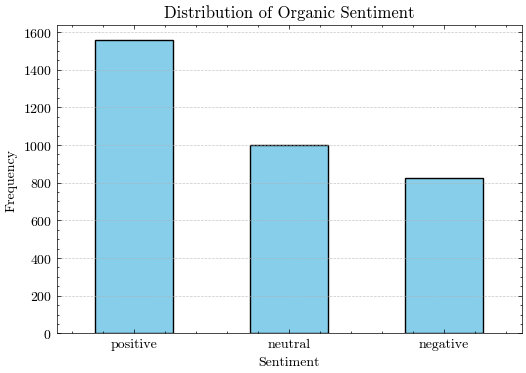

In [129]:
plt.figure(figsize=(6, 4))
df_reddit[df_reddit['assigned_topic'] == organic_topic_index]['vader_sentiment'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of Organic Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [131]:
df_sentiment = df_reddit[df_reddit['assigned_topic'] == organic_topic_index]
df_sentiment = df_sentiment.groupby(['country', 'year', 'vader_sentiment']).size().reset_index(name='count')
df_sentiment

,country,year,vader_sentiment,count
0,Austria,2015,neutral,1
1,Austria,2016,negative,4
2,Austria,2016,neutral,3
3,Austria,2016,positive,7
4,Austria,2017,negative,1
...,...,...,...,...
414,Sweden,2021,neutral,3
415,Sweden,2021,positive,4
416,Sweden,2022,negative,1
417,Sweden,2022,neutral,6


In [133]:
df_sentiment = df_reddit[df_reddit['assigned_topic'] == organic_topic_index]
df_sentiment = df_sentiment.groupby(['country', 'year', 'vader_sentiment']).size().reset_index(name='count')
df_sentiment = df_sentiment.pivot(index=['country', 'year'], columns='vader_sentiment', values='count').fillna(0).reset_index()

In [162]:
file_name = 'data/df_sentiment.csv'
df_sentiment.to_csv(file_name, index=False)

## Findings

Positive sentiment dominates discussions on organic farming, with significantly higher engagement levels compared to neutral and negative sentiments (Figure 1). Over time, positive sentiment has grown substantially, especially after 2015, with sharp increases from 2019 to 2022, likely driven by policy initiatives and increased public awareness (Figure 2). Geographically, Austria and Denmark lead in engagement, exhibiting overwhelmingly positive sentiment, while smaller countries like Czechia and Estonia show minimal activity (Figure 3). Additionally, proportional sentiment analysis underscores Austria and Denmark as leaders in positive sentiment, whereas Ireland and the Netherlands display more balanced sentiment distributions, reflecting regional variations in public attitudes (Figure 4). 

In [137]:
md_table = df_sentiment.describe()
display(Markdown(md_table.to_markdown()))

|       |       year |   negative |   neutral |   positive |
|:------|-----------:|-----------:|----------:|-----------:|
| count |  178       |  178       | 178       |  178       |
| mean  | 2018.39    |    4.64045 |   5.61236 |    8.74719 |
| std   |    2.74579 |    9.0138  |   8.24561 |   16.2372  |
| min   | 2012       |    0       |   0       |    0       |
| 25%   | 2016       |    0       |   1       |    1       |
| 50%   | 2019       |    1       |   2       |    3       |
| 75%   | 2021       |    4       |   6       |    8.75    |
| max   | 2022       |   48       |  47       |  103       |

In [169]:
colormap = {
    'negative': '#FF6F61',  # Deep red
    'neutral': '#FFCC80',   # Bright yellow
    'positive': '#4CAF50'   # Deep green
}

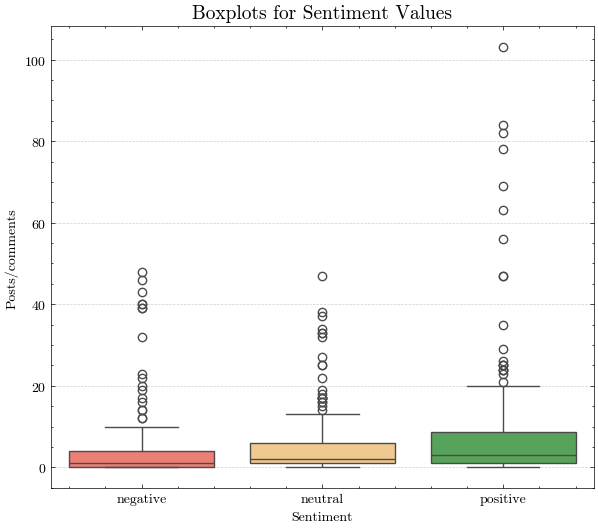

In [171]:
plt.figure(figsize=(7, 6))
sns.boxplot(data=df_sentiment[['negative', 'neutral', 'positive']], palette=colormap)
plt.title('Boxplots for Sentiment Values', fontsize=14)
plt.ylabel('Posts/comments')
plt.xlabel('Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [173]:
df_years = df_sentiment.groupby('year')[['negative', 'neutral', 'positive']].sum().reset_index()

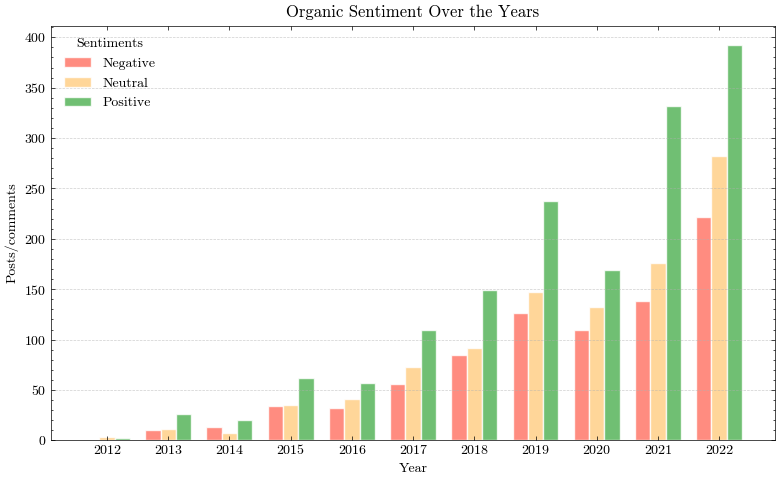

In [175]:
years = sorted(df_years['year'].unique())
width = 0.25

plt.figure(figsize=(8, 5))

x_indexes = range(len(years))
plt.bar([i - width for i in x_indexes], df_years['negative'], width=width, label='Negative', color=colormap['negative'], alpha=0.8, edgecolor='white', linewidth=1)
plt.bar(x_indexes, df_years['neutral'], width=width, label='Neutral', color=colormap['neutral'], alpha=0.8, edgecolor='white', linewidth=1)
plt.bar([i + width for i in x_indexes], df_years['positive'], width=width, label='Positive', color=colormap['positive'], alpha=0.8, edgecolor='white', linewidth=1)

plt.xticks(ticks=x_indexes, labels=years)
plt.gca().xaxis.set_minor_locator(ticker.NullLocator())

plt.title('Organic Sentiment Over the Years')
plt.xlabel('Year')
plt.ylabel('Posts/comments')
plt.legend(title="Sentiments")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [177]:
df_countries = df_sentiment.groupby('country')[['negative', 'neutral', 'positive']].sum().reset_index()
df_countries['total'] = df_countries[['negative', 'neutral', 'positive']].sum(axis=1)
df_countries = df_countries.sort_values(by='total', ascending=False)

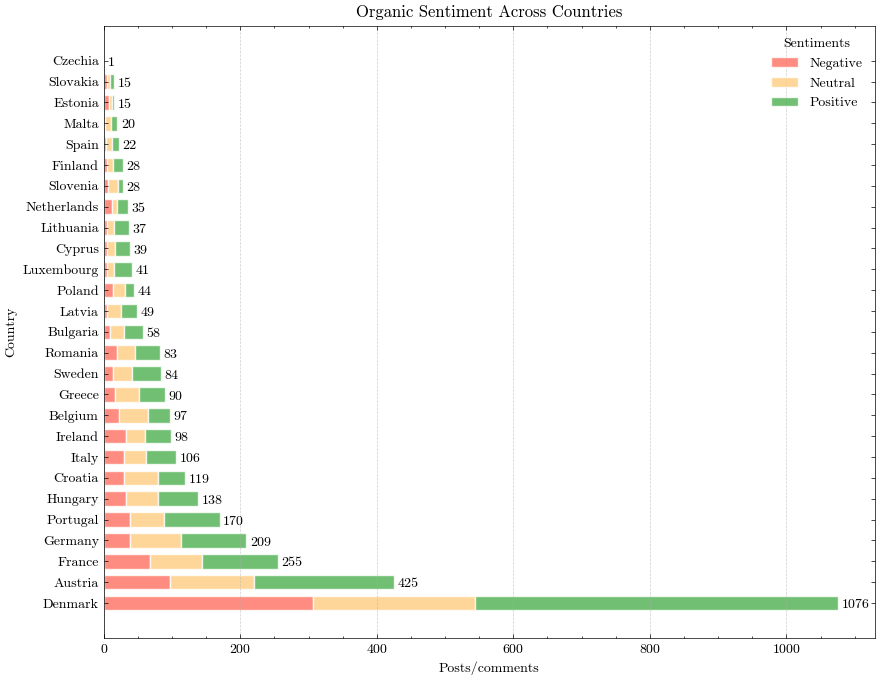

In [179]:
height = 0.7

plt.figure(figsize=(9, 7))

plt.barh(df_countries['country'], df_countries['negative'], label='Negative', color=colormap['negative'], alpha=0.8, edgecolor='white', height=height)
plt.barh(df_countries['country'], df_countries['neutral'], 
         left=df_countries['negative'], label='Neutral',  color=colormap['neutral'], alpha=0.8, edgecolor='white', height=height)
plt.barh(df_countries['country'], df_countries['positive'], 
         left=df_countries['negative'] + df_countries['neutral'], label='Positive', color=colormap['positive'], alpha=0.8, edgecolor='white', height=height)

for i, total in enumerate(df_countries['total']):
    plt.text(total + 5, i - 0.1, f"{int(total)}", va='center', color='black')

plt.title('Organic Sentiment Across Countries')
plt.ylabel('Country')
plt.xlabel('Posts/comments')
plt.legend(title="Sentiments")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout()
plt.show()

In [181]:
df_ratio = df_countries.copy()
df_ratio['total'] = df_ratio[['negative', 'neutral', 'positive']].sum(axis=1)
df_ratio['negative_ratio'] = df_ratio['negative'] / df_ratio['total']
df_ratio['neutral_ratio'] = df_ratio['neutral'] / df_ratio['total']
df_ratio['positive_ratio'] = df_ratio['positive'] / df_ratio['total']

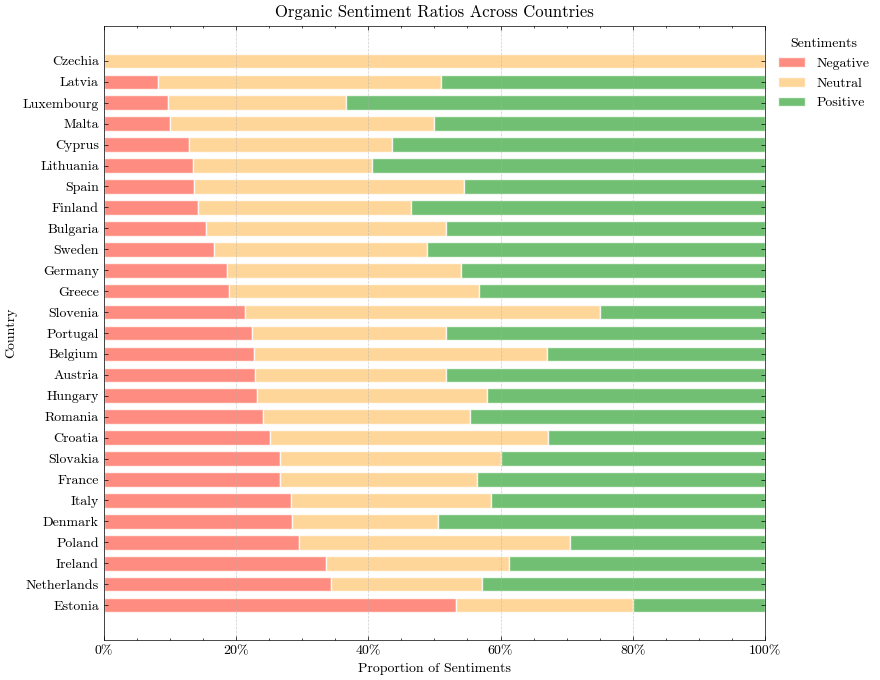

In [183]:
df_ratio = df_ratio.sort_values(by=['negative_ratio'], ascending=[False])

height = 0.7

plt.figure(figsize=(9, 7))

plt.barh(df_ratio['country'], df_ratio['negative_ratio'], label='Negative', color=colormap['negative'], alpha=0.8, height=height, edgecolor='white')
plt.barh(df_ratio['country'], df_ratio['neutral_ratio'], 
         left=df_ratio['negative_ratio'], label='Neutral', color=colormap['neutral'], alpha=0.8, height=height, edgecolor='white')
plt.barh(df_ratio['country'], df_ratio['positive_ratio'], 
         left=df_ratio['negative_ratio'] + df_ratio['neutral_ratio'], label='Positive', color=colormap['positive'], alpha=0.8, height=height, edgecolor='white')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plt.title('Organic Sentiment Ratios Across Countries')
plt.ylabel('Country')
plt.xlabel('Proportion of Sentiments')
plt.legend(title="Sentiments", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout()
plt.show()

In [185]:
selected_countries = ['Ireland', 'Finland', 'Belgium', 'Austria', 'Bulgaria', 'Romania', 'Sweden', 'Portugal', 'Malta']

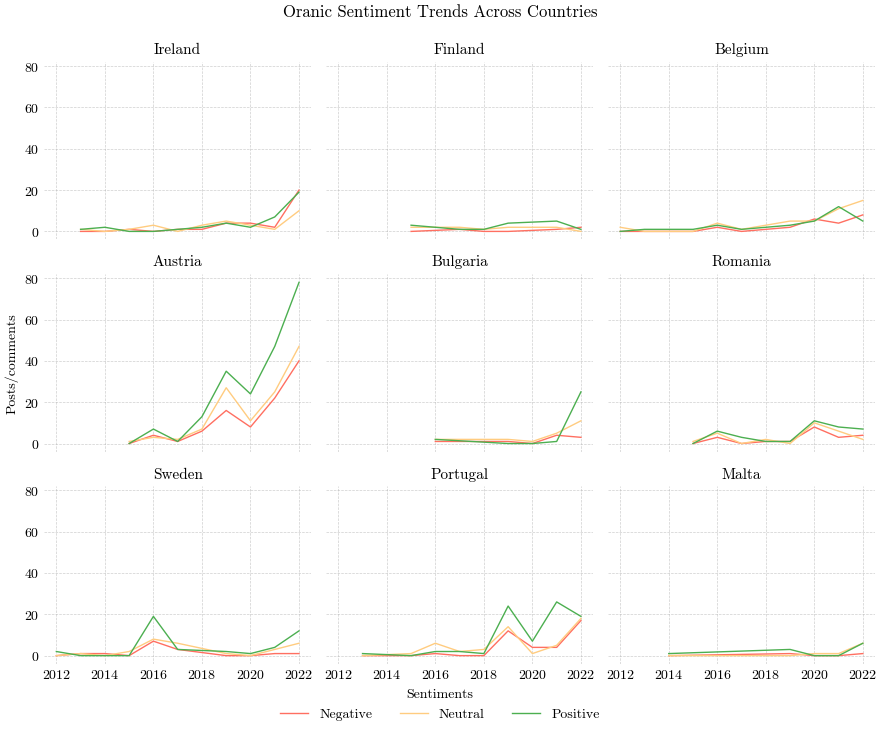

In [187]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharex=True, sharey=True)
axes = axes.flatten()

for idx, country in enumerate(selected_countries):
    ax = axes[idx]
    df_country = df_sentiment[df_sentiment['country'] == country]

    for sentiment, color in colormap.items():
        if sentiment in df_country.columns:
            ax.plot(df_country['year'], df_country[sentiment], label=sentiment.capitalize(), color=color)
    
    ax.set_title(country, fontsize=11)
    ax.grid(linestyle='--', alpha=0.6)

    if idx == 3:
        ax.set_ylabel('Posts/comments')

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.tick_params(top=False, right=False, left=False, bottom=False)
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    ax.yaxis.set_minor_locator(ticker.NullLocator())

fig.suptitle('Oranic Sentiment Trends Across Countries', y=0.99)
fig.tight_layout()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=3, title="Sentiments", bbox_to_anchor=(0.5, -0.01))

plt.show()

In [99]:
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.2f} seconds")

Execution time: 1280.15 seconds


In [2]:
# Automatic report creation

In [8]:
# !jupyter nbconvert "CA2_notebook-sentiment.ipynb" --no-input --to markdown --output-dir="report" --TagRemovePreprocessor.remove_cell_tags="['hide']"

[NbConvertApp] Converting notebook CA2_notebook-sentiment.ipynb to markdown
[NbConvertApp] Support files will be in CA2_notebook-sentiment_files\
[NbConvertApp] Making directory report\CA2_notebook-sentiment_files
[NbConvertApp] Writing 20687 bytes to report\CA2_notebook-sentiment.md


In [10]:
# %cd report
# !pandoc "CA2_notebook-sentiment.md" -s -o "CA2_notebook-sentiment.docx" --reference-doc=report_template.docx
# %cd ..

D:\College\CA\CA2\msc-da-sept-24-sem-1-ca2-sba24277\report
D:\College\CA\CA2\msc-da-sept-24-sem-1-ca2-sba24277
